**Load Dataset**

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.datasets import fetch_california_housing

warnings.filterwarnings("ignore")

# Load the dataset
california_housing = fetch_california_housing(as_frame=True)
data = california_housing.frame

# Display basic information about the dataset
print(data.info())
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.

**Exploratory Data Analysis**


---


Correlation Heatmap

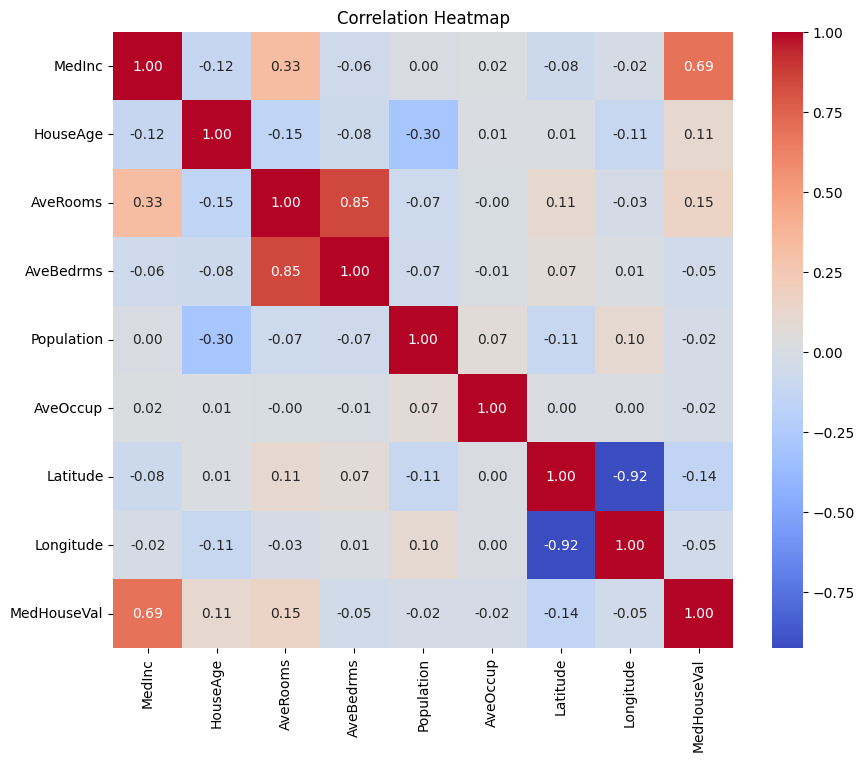

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Pairplot of Features

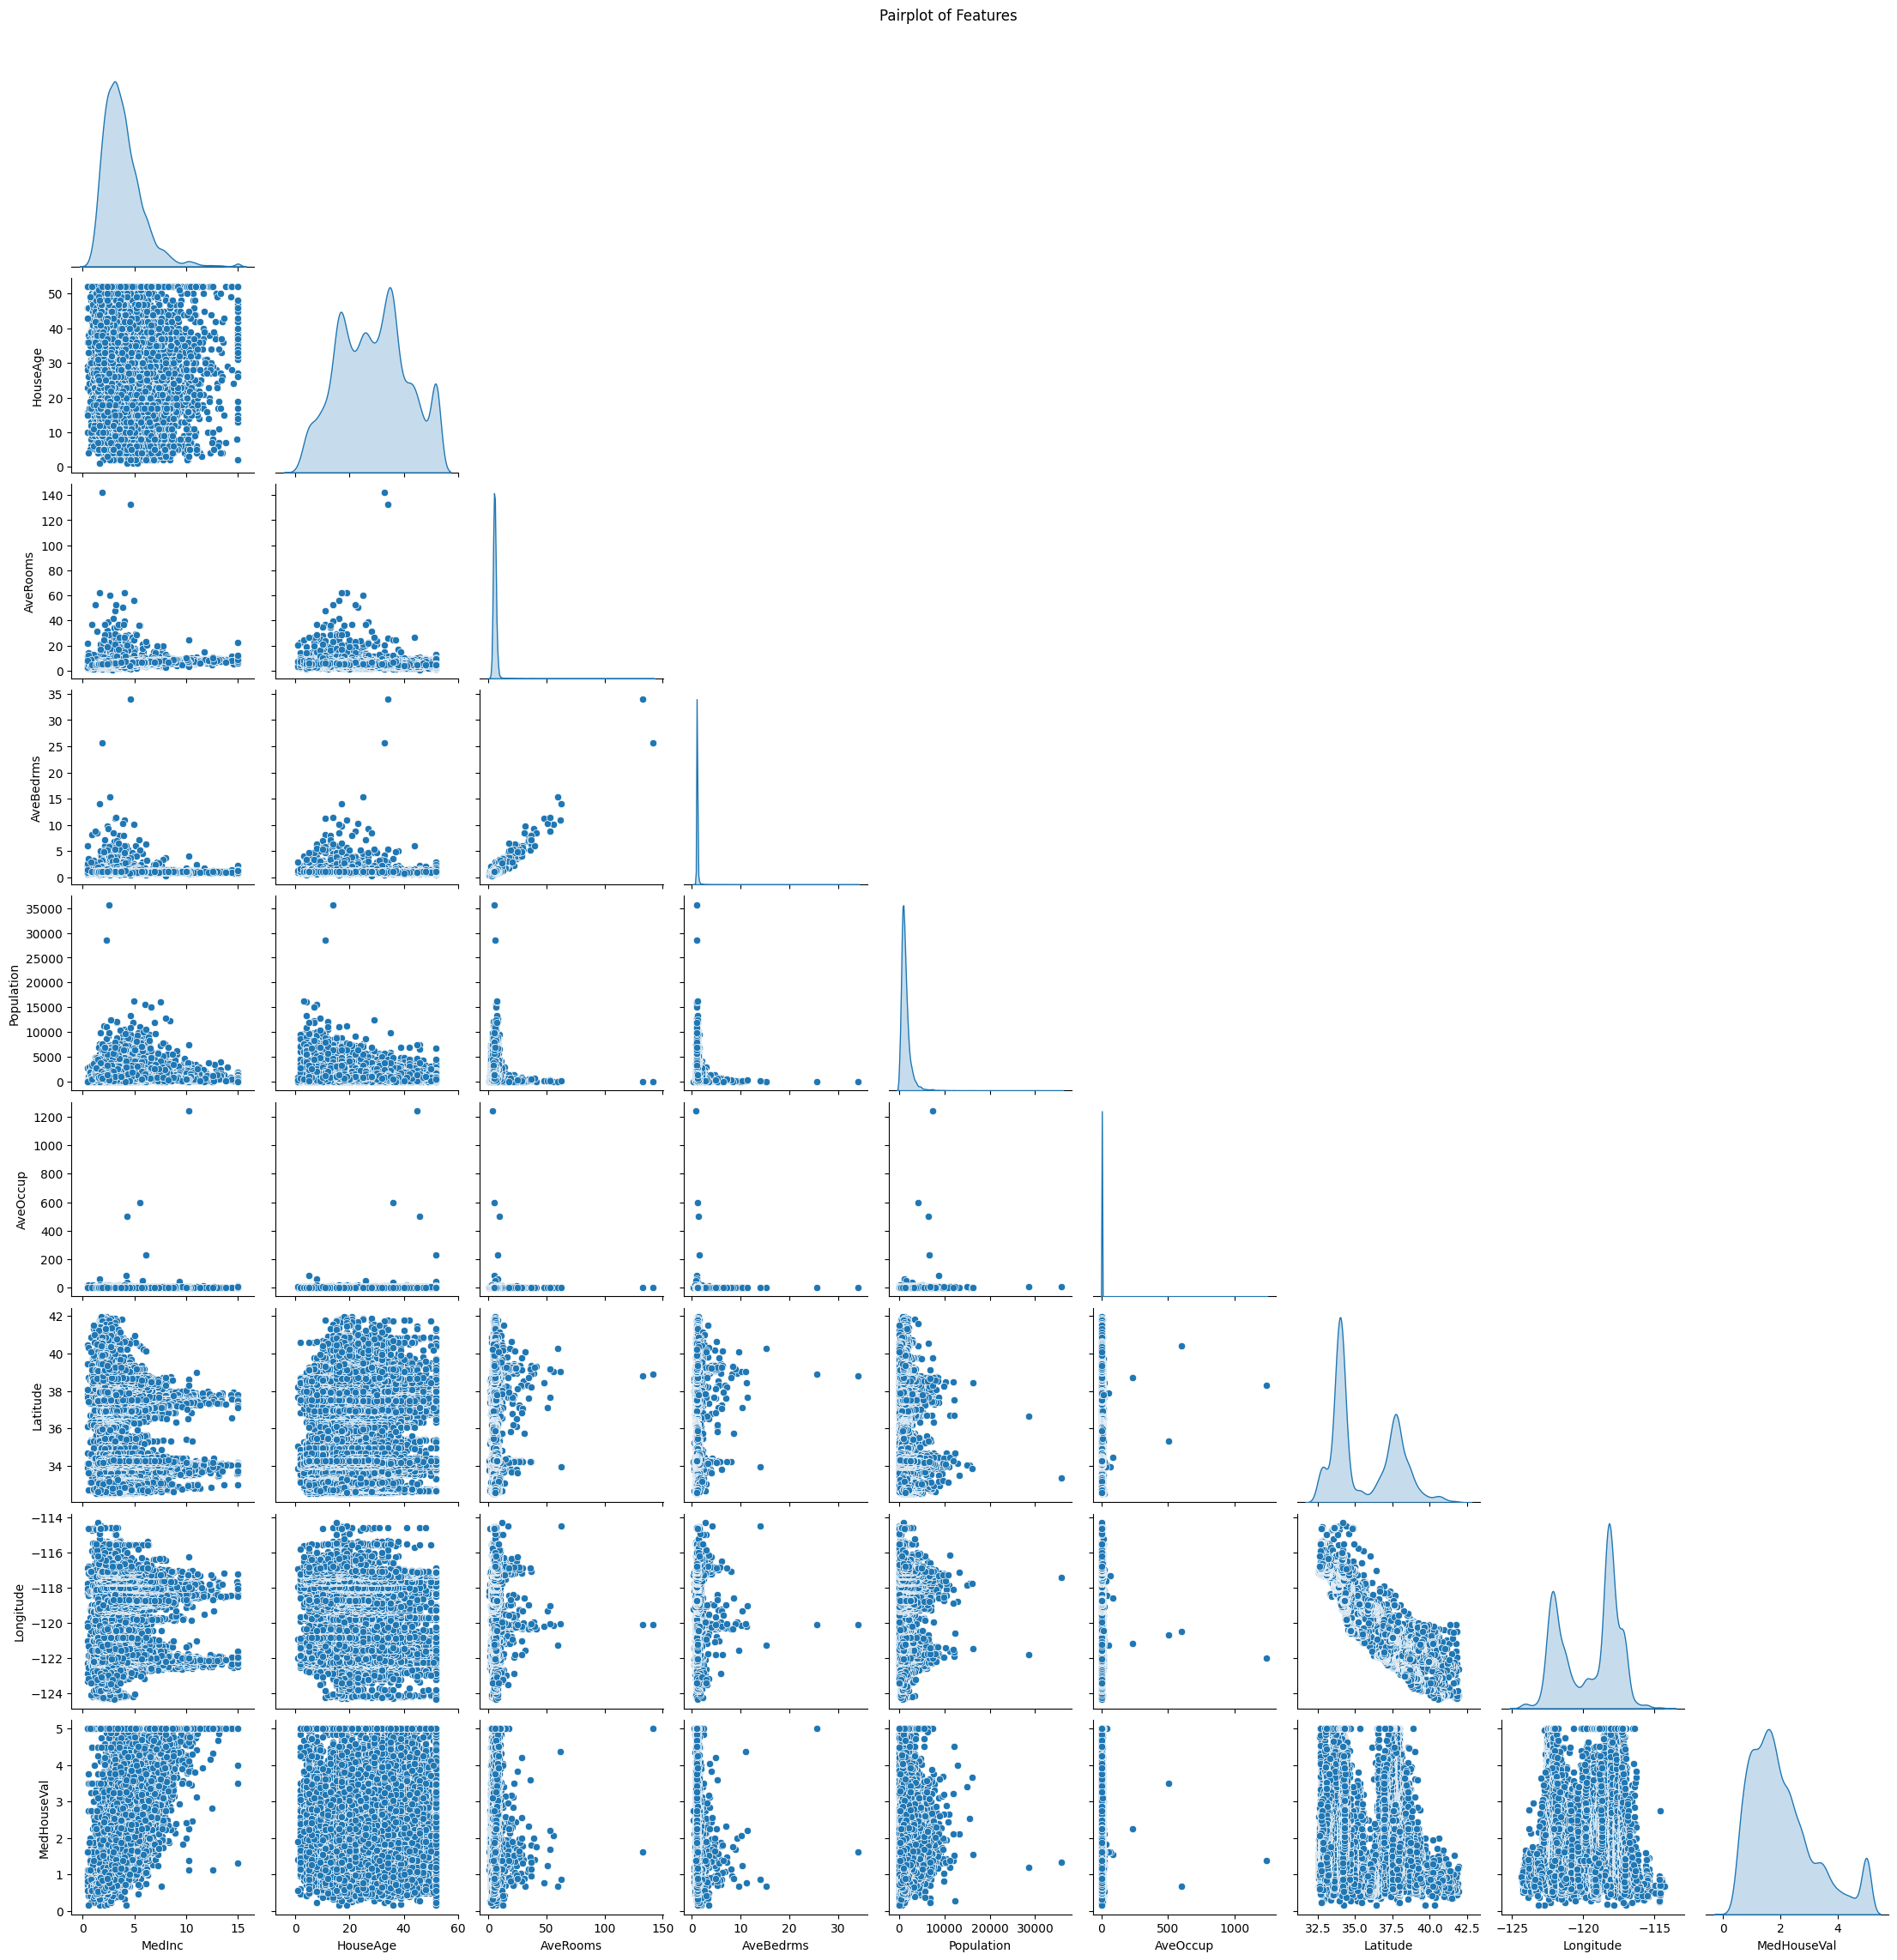

In [ ]:
sns.pairplot(data, diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()


Feature Distributions

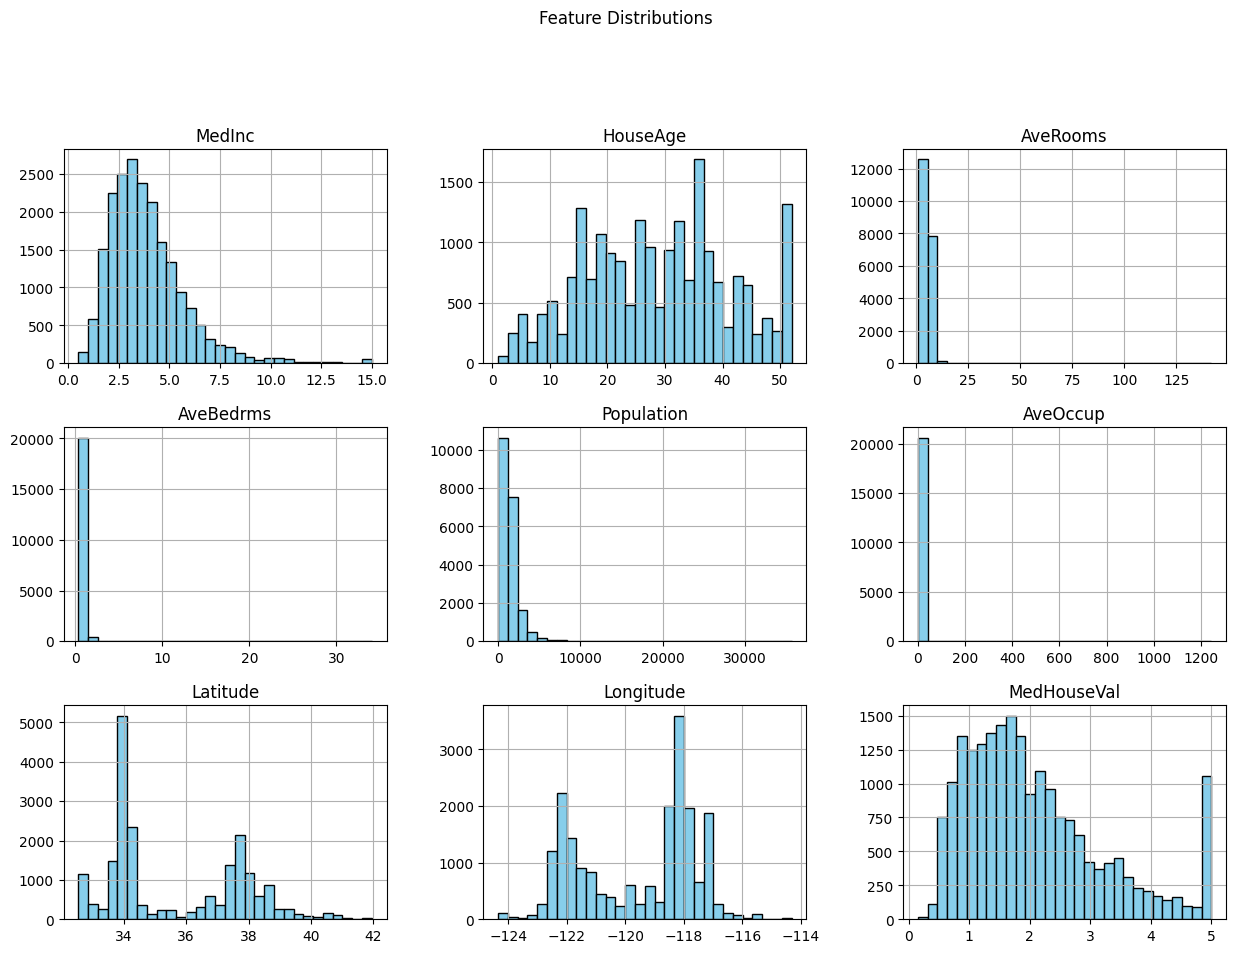

In [ ]:
# Histogram for each feature
data.hist(figsize=(15, 10), bins=30, color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions", y=1.02)
plt.show()

Boxplot for Outlier Detection

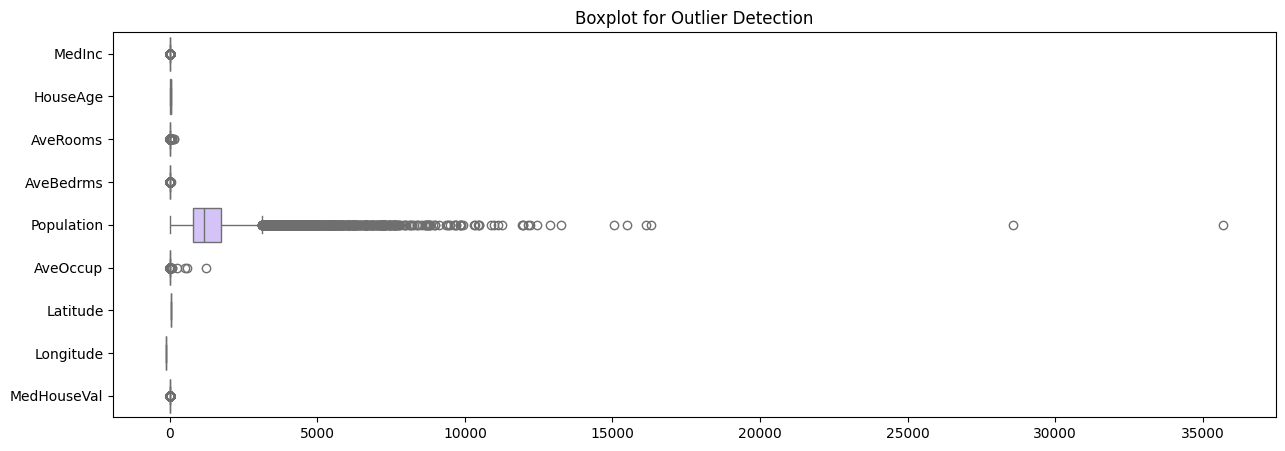

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data, orient="h", palette="pastel")
plt.title("Boxplot for Outlier Detection")
plt.show()


Distribution of Median House Value

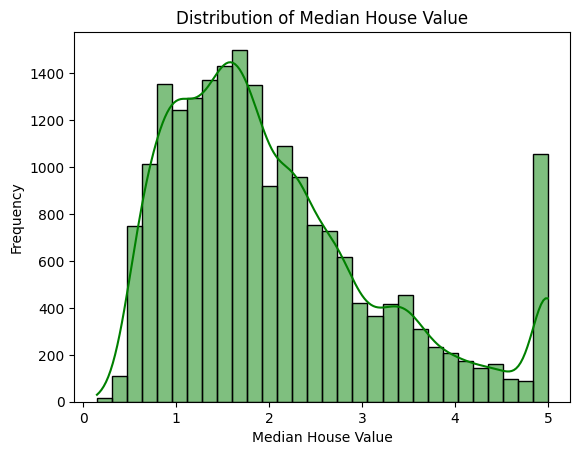

In [ ]:
sns.histplot(data["MedHouseVal"], kde=True, bins=30, color="green")
plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.show()


**Machine Learning Models**


---

Data Preprocessing

In [ ]:
# Features and target
X = data.drop("MedHouseVal", axis=1)
y = data["MedHouseVal"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define evaluation function
def evaluate_model(model, X_test, y_test, predictions):
    print("Model Performance:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, predictions):.2f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, predictions):.2f}")
    print(f"R-squared (R2): {r2_score(y_test, predictions):.2f}")


Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
predictions_lr = lr.predict(X_test_scaled)
print("Linear Regression:")
evaluate_model(lr, X_test_scaled, y_test, predictions_lr)


Linear Regression:
Model Performance:
Mean Absolute Error (MAE): 0.53
Mean Squared Error (MSE): 0.56
R-squared (R2): 0.58


Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
predictions_rf = rf.predict(X_test_scaled)
print("Random Forest Regressor:")
evaluate_model(rf, X_test_scaled, y_test, predictions_rf)


Random Forest Regressor:
Model Performance:
Mean Absolute Error (MAE): 0.33
Mean Squared Error (MSE): 0.26
R-squared (R2): 0.81


Hyperparameter Tuning

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
tuned_predictions_rf = best_rf.predict(X_test_scaled)
print("Tuned Random Forest:")
evaluate_model(best_rf, X_test_scaled, y_test, tuned_predictions_rf)


Tuned Random Forest:
Model Performance:
Mean Absolute Error (MAE): 0.33
Mean Squared Error (MSE): 0.25
R-squared (R2): 0.81


**Forecasting**

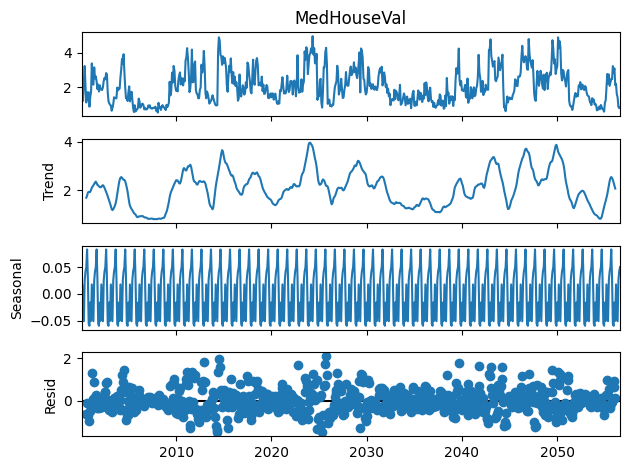

In [8]:
# Generate a reasonable time index by scaling the frequency
data["Time_Index"] = pd.date_range(start="2000-01-01", periods=len(data), freq="D")  # Use 'D' instead of 'M'
data.set_index("Time_Index", inplace=True)

# Aggregate data to monthly averages
house_values = data["MedHouseVal"].resample("M").mean()

# Decompose the time series
result = seasonal_decompose(house_values.dropna(), model="additive")
result.plot()
plt.show()


Exponential Smoothing

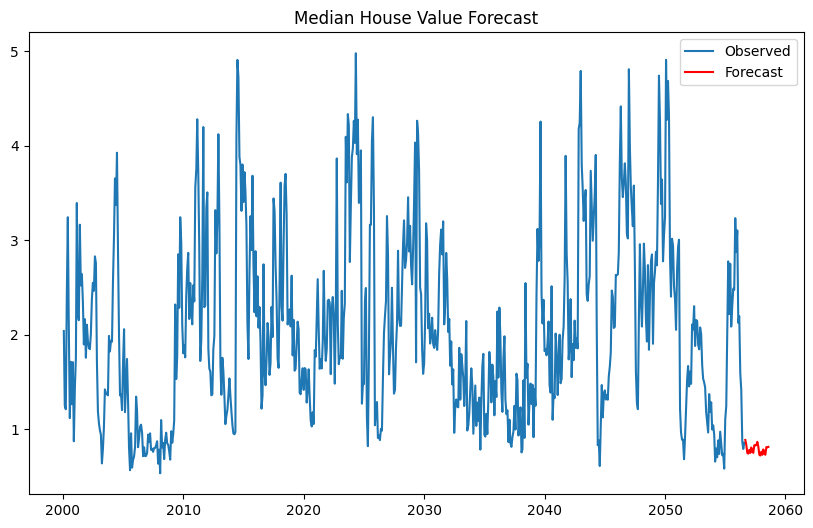

In [9]:
# Holt-Winters Exponential Smoothing
model = ExponentialSmoothing(house_values, trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
forecast = fit.forecast(24)  # Forecast for the next 2 years

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(house_values, label="Observed")
plt.plot(forecast, label="Forecast", color="red")
plt.title("Median House Value Forecast")
plt.legend()
plt.show()
